<a href="https://colab.research.google.com/github/s-mishra/statrethinking_lectures_numpyro/blob/main/week3/iwona_rethinking_week3_chapters5_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Useful links:

* [HOMEWORK](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework)

* [Book code translated into NumPyro](https://fehiepsi.github.io/rethinking-numpyro/)

* [Book and homework code in Python/PyMC3](https://github.com/pymc-devs/resources/tree/master/Rethinking_2)

* [NumPyro documentation](http://num.pyro.ai/en/stable/api.html)

* [NumPyro examples](http://num.pyro.ai/en/latest/index.html#introductory-tutorials)

* [Other languagaes and videos](https://github.com/rmcelreath/stat_rethinking_2020)

In [ ]:
!pip install numpyro


In [ ]:
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist

az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")



```
`# This is formatted as code`
```

# Homework week 3

 https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework/week03

All three problems below are based on the same data. The data in data(foxes) are 116 foxes from 30 different urban groups in England. These foxes are like street gangs. Group size varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The area variable encodes this information. Some territories also have more avgfood than others. We want to model the weight of each fox. For the problems below, assume this DAG:
 

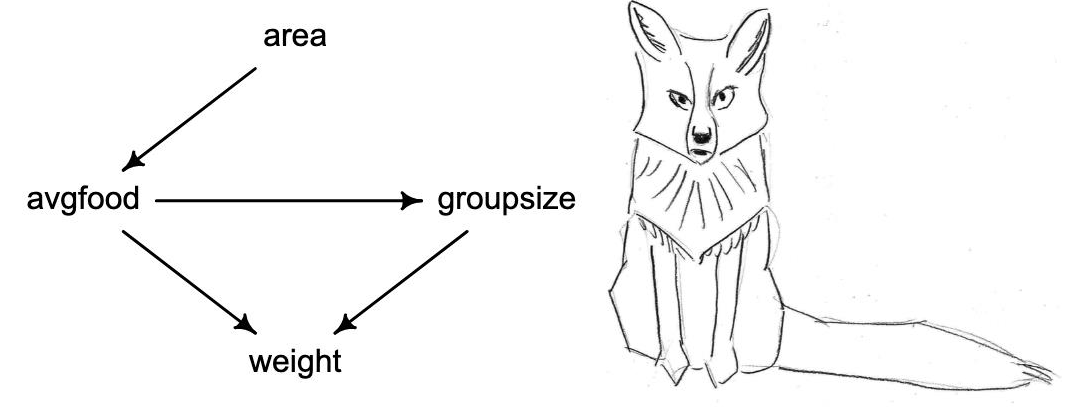

In [ ]:
# load the dataset with the foxes data from github
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv', delimiter=';')
df.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [ ]:
from sklearn.preprocessing import StandardScaler
df_std = df.copy()
df_std[['avgfood', 'groupsize', 'area', 'weight']] = StandardScaler().fit_transform(df_std[['avgfood', 'groupsize', 'area', 'weight']])
df_std.head()

,group,avgfood,groupsize,area,weight
0,1,-1.933180,-1.530701,-2.249313,0.415931
1,1,-1.933180,-1.530701,-2.249313,-1.433238
2,2,-1.122886,-1.530701,-1.210738,0.678887
3,2,-1.122886,-1.530701,-1.210738,1.306586
4,3,-1.325459,-1.530701,-1.135008,1.119973


## Before I do the exercises I'll check a model with all covariates to see if there are any incorrect conclusions I would have made before learning anything about causal inference

In [79]:
def model0(food=None, groupsize=None, area=None, weight=None):
    # priors
    alpha = numpyro.sample("alpha", dist.Normal(0,0.5))
    beta_f = numpyro.sample("beta_food", dist.Normal(0, 0.5))
    beta_gs = numpyro.sample("beta_groupsize", dist.Normal(0, 0.5))
    beta_a = numpyro.sample("beta_area", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.InverseGamma(1))
    # deterministic
    mu = numpyro.deterministic("mu", alpha + beta_f * food + beta_gs * groupsize + beta_a * area)
    # likelihood
    numpyro.sample("weight", dist.Normal(mu, sigma), obs=weight) 

In [80]:
nuts_kernel0 = numpyro.infer.NUTS(model0)

mcmc0 = numpyro.infer.MCMC(nuts_kernel0, num_chains=4, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc0.run(rng_key, food=df_std.avgfood.values , groupsize=df_std.groupsize.values, 
          area=df_std.area.values, weight=df_std.weight.values)
mcmc0.print_summary()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 4000/4000 [00:00<00:00, 7484.41it/s, 15 steps of size 2.68e-01. acc. prob=0.94]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha     -0.00      0.09     -0.00     -0.15      0.14   6748.62      1.00
       beta_area      0.28      0.17      0.28     -0.00      0.56   6619.87      1.00
       beta_food      0.29      0.21      0.29     -0.06      0.64   5436.64      1.00
  beta_groupsize     -0.63      0.19     -0.64     -0.95     -0.34   6438.68      1.00
           sigma      0.96      0.06      0.96      0.86      1.07   6630.99      1.00

Number of divergences: 0


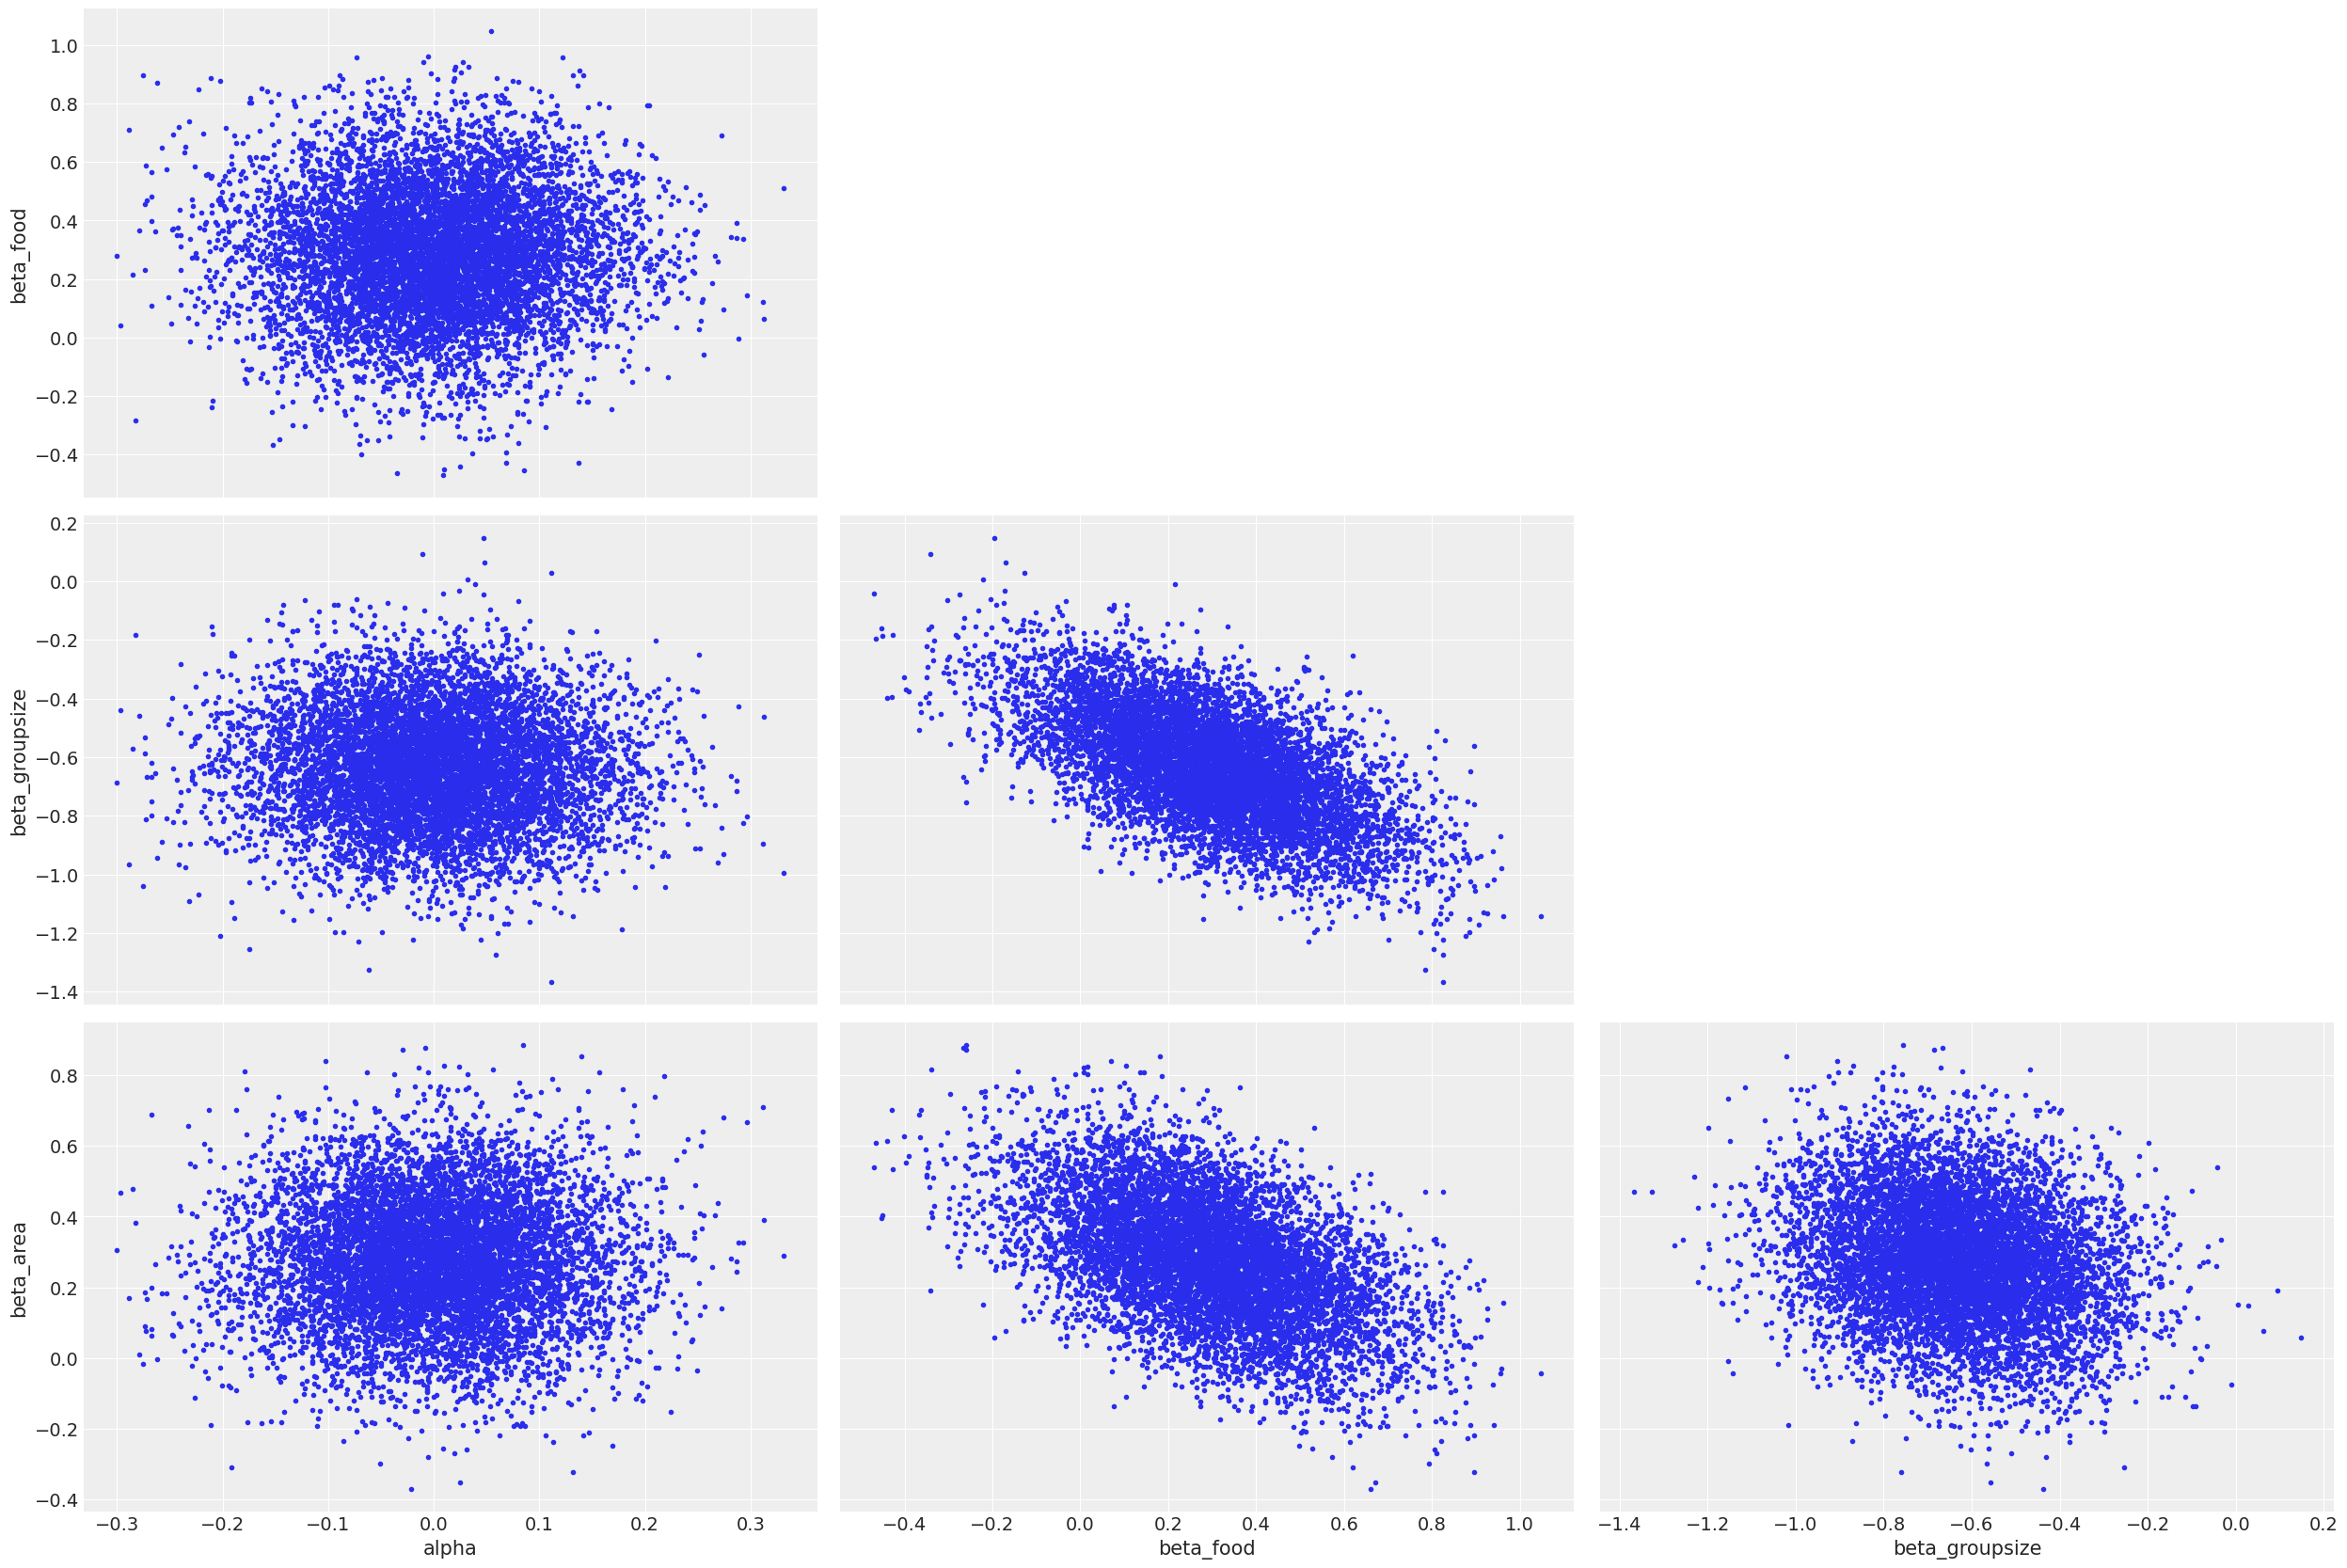

In [82]:
data0 = az.from_numpyro(mcmc0)
az.plot_pair(
    data0, var_names=["alpha", "beta_food", "beta_groupsize", "beta_area"], divergences=True
);

So in this model only groupsize is always negatively correlated

## Exercise 1


Use a model to infer the total causal influence of area on weight. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the possible outcome range.

No backdoor on the area. So we can make a simple linear model (like in the last set of exercises) f(area) --> weight

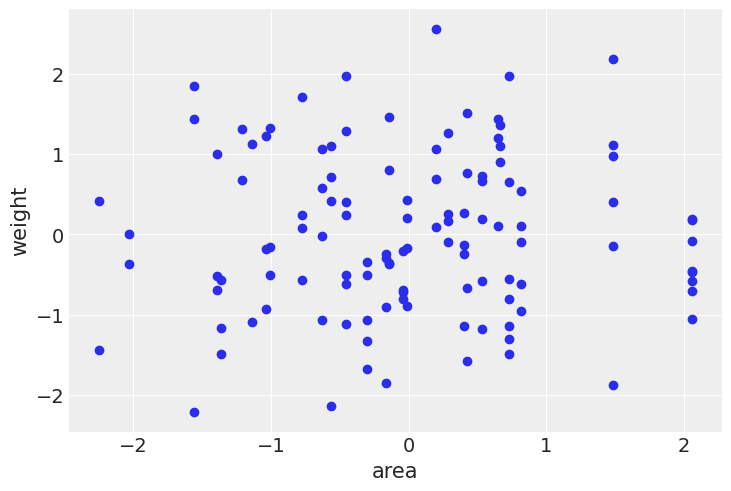

In [ ]:
plt.scatter(df_std.area.values, df_std.weight.values)
plt.xlabel('area')
plt.ylabel('weight')
plt.show()

In [ ]:
def model(area=None, weight=None):
    # priors
    alpha = numpyro.sample("alpha", dist.Normal(0,0.5))
    beta = numpyro.sample("beta", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.InverseGamma(1))
    # deterministic
    mu = numpyro.deterministic("mu", alpha + beta * area)
    # likelihood
    numpyro.sample("weight", dist.Normal(mu, sigma), obs=weight) 

We will do a prior predictive check first

In [ ]:
area_for_prior = jnp.linspace(-2.5, 2.5)

[]

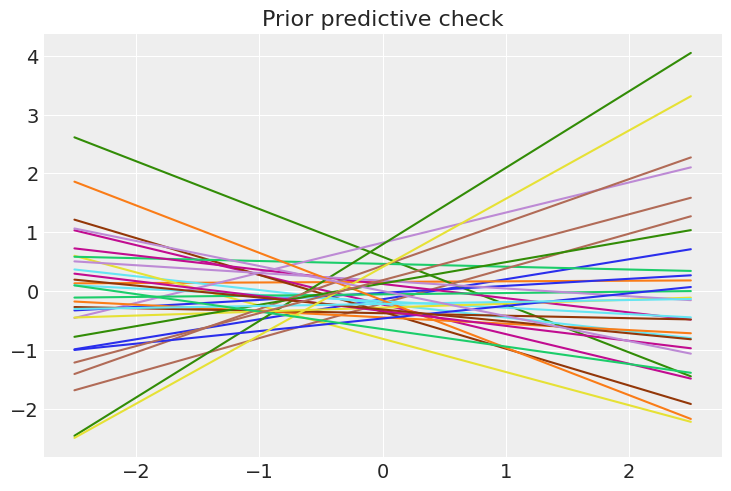

In [ ]:
prior_predictive = numpyro.infer.Predictive(model, num_samples=30)
prior_predictions = prior_predictive(random.PRNGKey(0), area=area_for_prior, weight=None)
mu = prior_predictions['mu']
for i in range(len(mu)):
  plt.plot(area_for_prior,mu[i,:])
plt.title('Prior predictive check')
plt.plot()

Priors look fine to me

In [ ]:
nuts_kernel = numpyro.infer.NUTS(model)

mcmc = numpyro.infer.MCMC(nuts_kernel, num_chains=4, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, area=df_std.area.values, weight=df_std.weight.values)

posterior_samples = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 4000/4000 [00:00<00:00, 8615.22it/s, 1 steps of size 8.74e-01. acc. prob=0.90]


In [ ]:
# posterior_samples_for_print = posterior_samples.copy()
# posterior_samples_for_print.pop("mu")  # just because it will print mu[i] for each person in the dataset
# numpyro.diagnostics.print_summary(posterior_samples_for_print, 0.89, False)

In [ ]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.00      0.09     -0.00     -0.15      0.15   7597.15      1.00
      beta      0.02      0.09      0.02     -0.13      0.18   8057.36      1.00
     sigma      1.01      0.07      1.01      0.91      1.12   7215.98      1.00

Number of divergences: 0


So we look here at the slope (beta) and we see that it's values are sometimes negative and sometimes positive, so we can't make a conclusion that area has a causal effect on weight

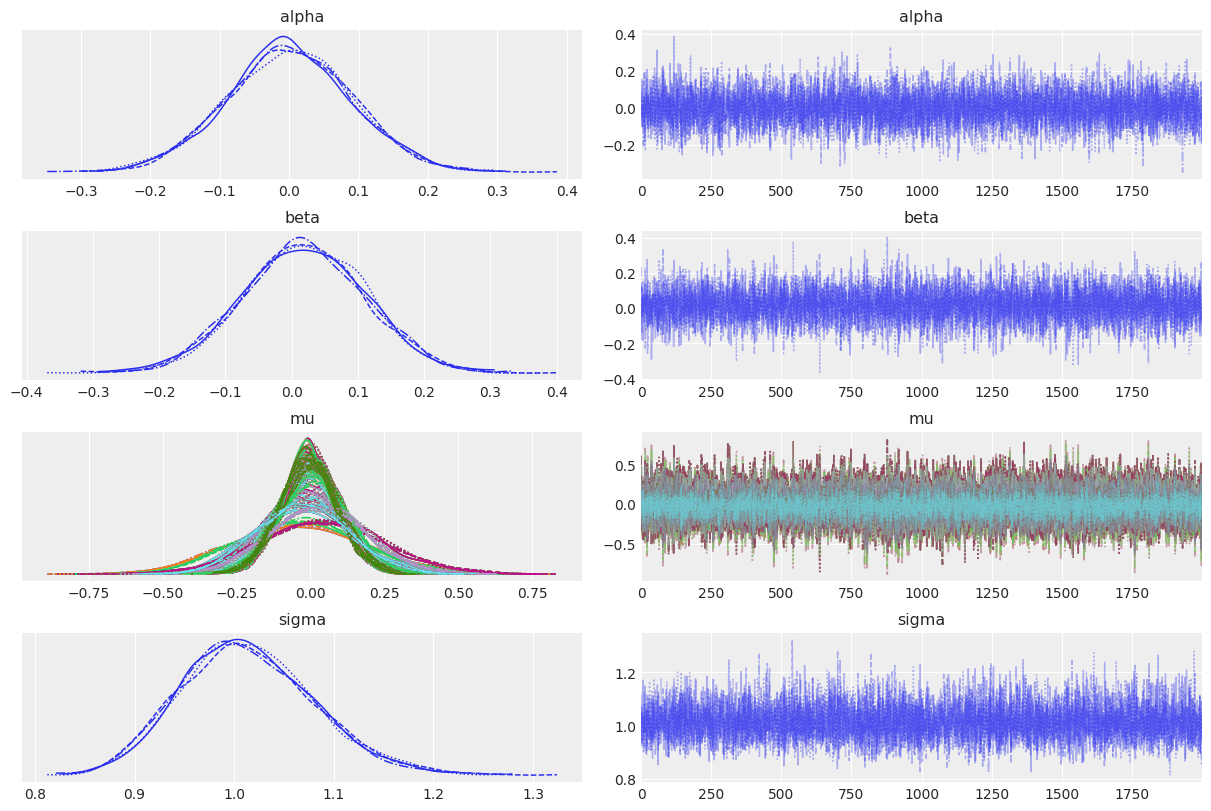

In [ ]:
# check the chains
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

## Exercise 2

Now infer the causal impact of adding food (avgfood) to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

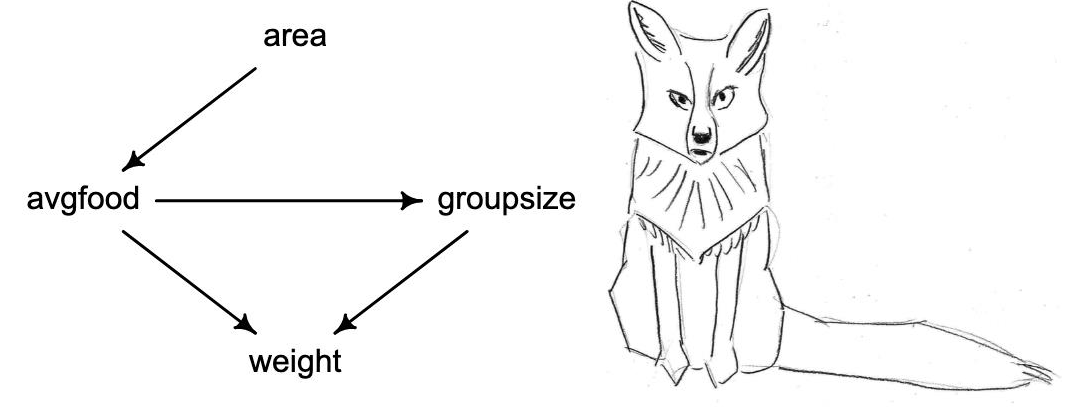

No backdoor on the avgfood. So again a simple linear model will do.

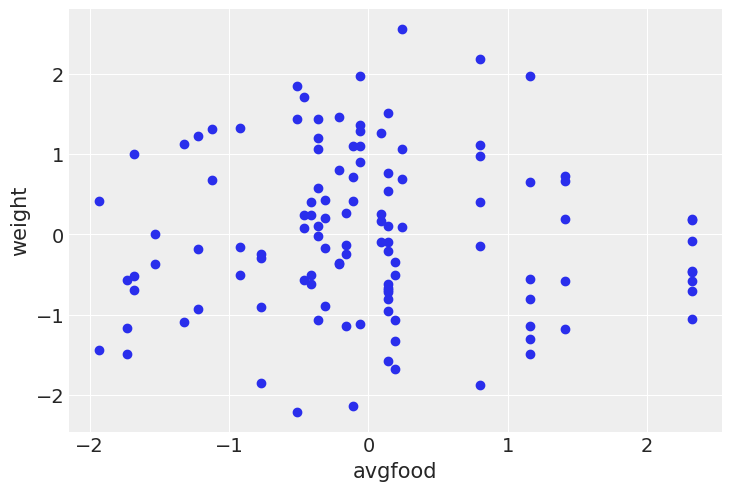

In [ ]:
plt.scatter(df_std.avgfood.values, df_std.weight.values)
plt.xlabel('avgfood')
plt.ylabel('weight')
plt.show()

In [ ]:
def model2(food=None, weight=None):
    # priors
    alpha = numpyro.sample("alpha", dist.Normal(0, 0.5))
    beta = numpyro.sample("beta", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.InverseGamma(1))
    # deterministic
    mu = numpyro.deterministic("mu", alpha + beta * food)
    # likelihood
    numpyro.sample("weight", dist.Normal(mu, sigma), obs=weight) 

In [ ]:
nuts_kernel2 = numpyro.infer.NUTS(model2)

mcmc2 = numpyro.infer.MCMC(nuts_kernel2, num_chains=4, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc2.run(rng_key, food=df_std.avgfood.values, weight=df_std.weight.values)

posterior_samples2 = mcmc.get_samples()

mcmc2.print_summary()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 4000/4000 [00:00<00:00, 8890.70it/s, 1 steps of size 7.93e-01. acc. prob=0.92]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.00      0.09     -0.00     -0.15      0.15   7293.39      1.00
      beta     -0.02      0.09     -0.02     -0.17      0.13   8250.05      1.00
     sigma      1.01      0.07      1.01      0.91      1.13   6658.34      1.00

Number of divergences: 0


Same story. We can't conclude a causal effect of food on weight.

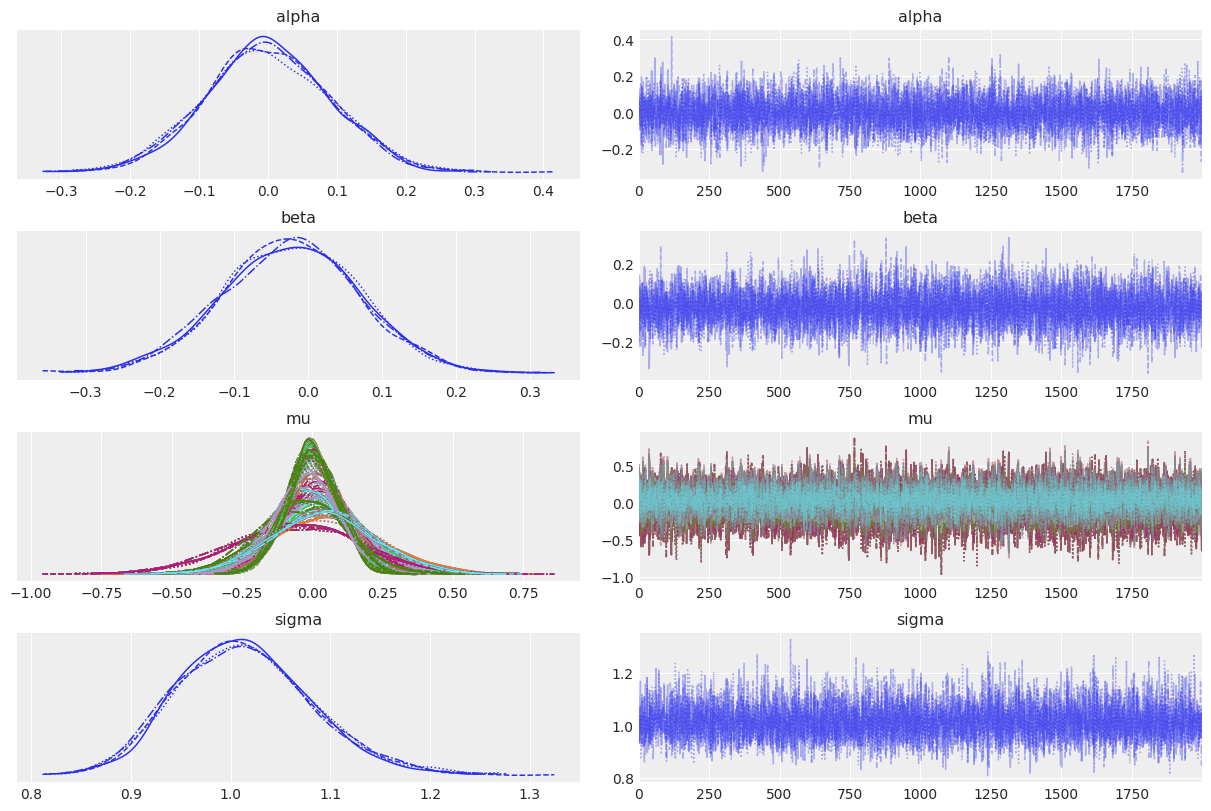

In [ ]:
# check the chains
data2 = az.from_numpyro(mcmc2)
az.plot_trace(data2, compact=True);

## Exercise 3

Now infer the causal impact of group size. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they make sense together?

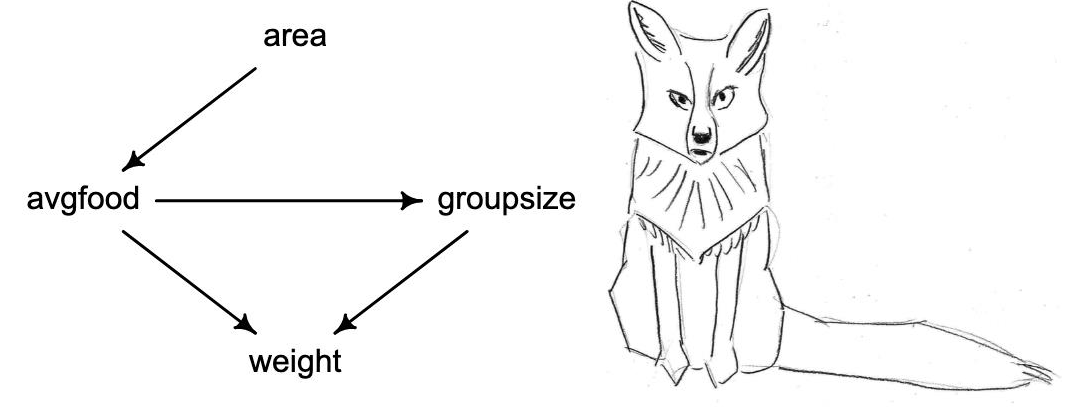

Groupsize has a backdoor path, through food. So we need to include food as well as groupsize in the model.

(we do not need area because area -> avgfood, but no backdoor path on area)

In [ ]:
def model3(food=None, groupsize=None, weight=None):
    # priors
    alpha = numpyro.sample("alpha", dist.Normal(0, 0.5))
    beta_food = numpyro.sample("beta_food", dist.Normal(0, 0.5))
    beta_groupsize = numpyro.sample("beta_groupsize", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.InverseGamma(1))
    # deterministic
    mu = numpyro.deterministic("mu", alpha + beta_food * food + beta_groupsize * groupsize)
    # likelihood
    numpyro.sample("weight", dist.Normal(mu, sigma), obs=weight) 

In [ ]:
nuts_kernel3 = numpyro.infer.NUTS(model3)

mcmc3 = numpyro.infer.MCMC(nuts_kernel3, num_chains=4, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc3.run(rng_key, food=df_std.avgfood.values,  groupsize = df_std.groupsize.values, weight=df_std.weight.values)

posterior_samples3 = mcmc.get_samples()

mcmc3.print_summary()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 4000/4000 [00:00<00:00, 8078.93it/s, 7 steps of size 3.65e-01. acc. prob=0.92] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha     -0.00      0.09      0.00     -0.14      0.14   5765.43      1.00
       beta_food      0.47      0.18      0.47      0.17      0.78   4034.08      1.00
  beta_groupsize     -0.57      0.18     -0.57     -0.86     -0.27   4064.95      1.00
           sigma      0.97      0.07      0.96      0.86      1.07   5680.88      1.00

Number of divergences: 0


So now it looks like groupsize has a causal effect when we condition on the food (negative effect: the bigger the group the smaller the weight of a fox in that group)

--> the bigger the group, the less food for each fox, so each fox weights less


And food has a positive causal effect when we condition on the groupsize.

--> the more food per group, the heavier the fox. We saw in Ex.2 that there is no direct causal effect of food on weight though, we need to control for the group size. 




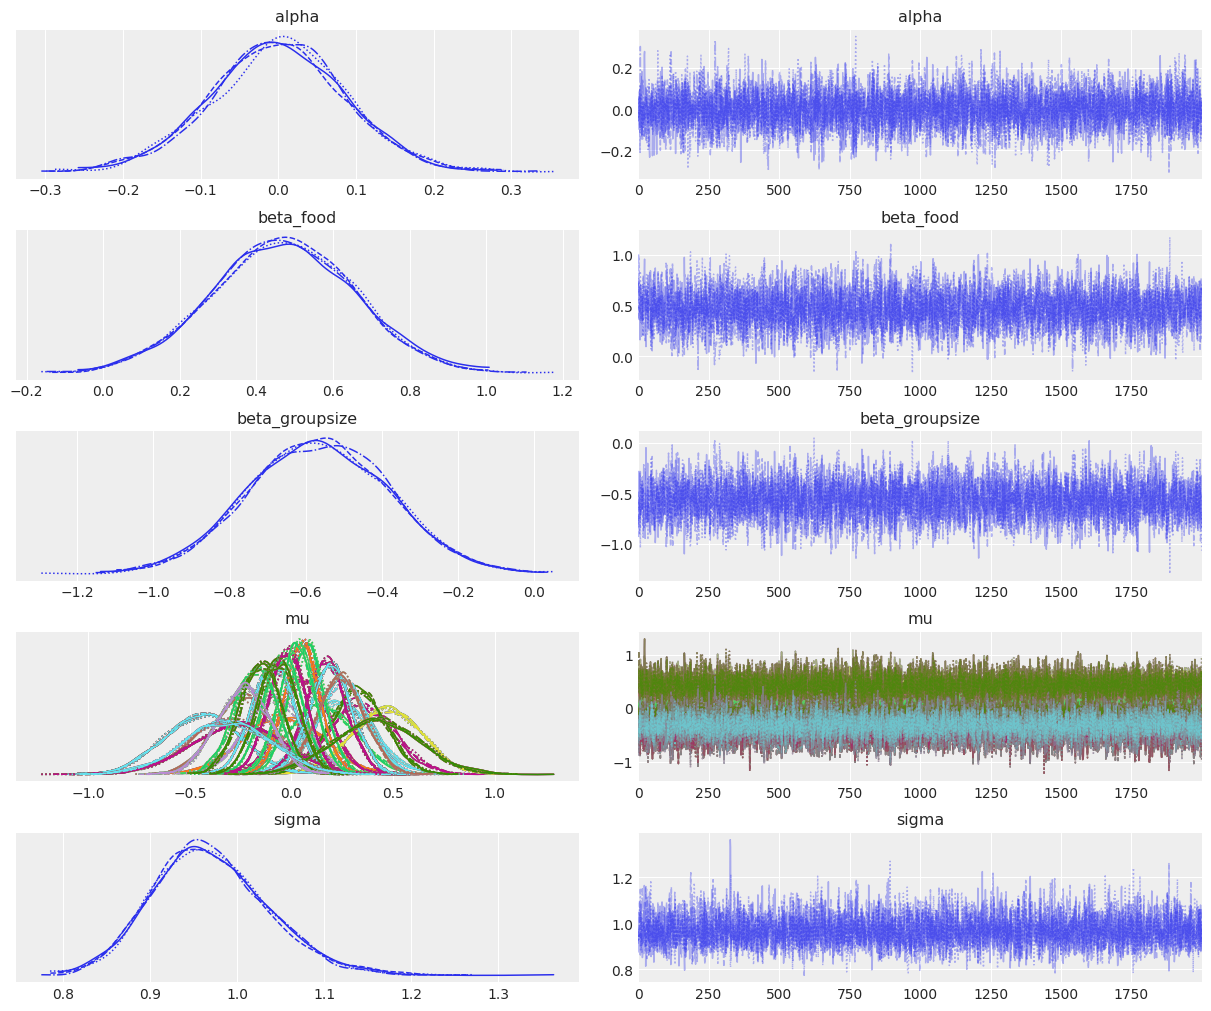

In [ ]:
# check the chains
data3 = az.from_numpyro(mcmc3)
az.plot_trace(data3, compact=True);

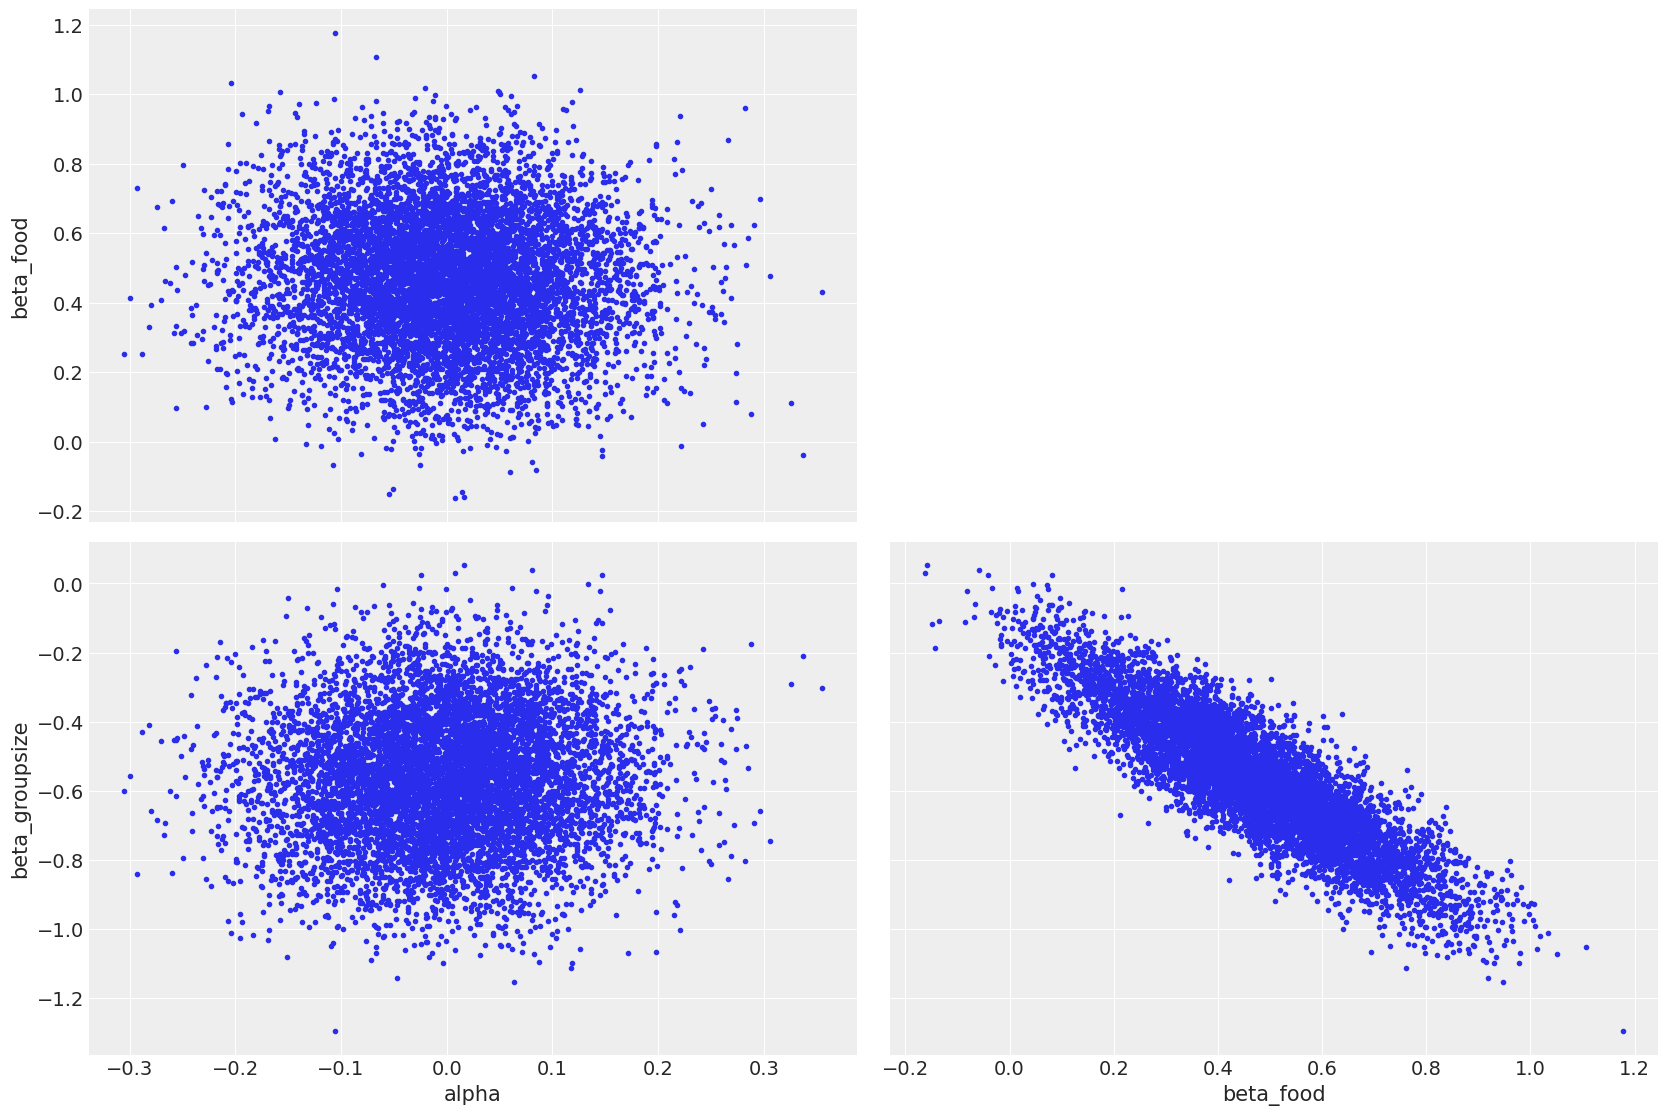

In [ ]:
az.plot_pair(
    data3, var_names=["alpha", "beta_food", "beta_groupsize"], divergences=True
);
# plt.show()